In [66]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
# import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
#plt.style.use('fivethirtyeight')
import xgboost as xgb
import sklearn
import random
from NecessaryModules.getData import getData
from NecessaryModules.splitData import split_data


In [67]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

# prepare data

In [68]:
filename = 'Dataset/ionosphere.csv'
dataset,label=getData(filename)
# dataset=pd.DataFrame(dataset) #from dataset_list to dataset_dataframe after suffling
print(dataset)
print(label)

[[1.0, 0.0, 0.99539, -0.05889, 0.85243, 0.02306, 0.83398, -0.37708, 1.0, 0.0376, 0.85243, -0.17755, 0.59755, -0.44945, 0.60536, -0.38223, 0.84356, -0.38542, 0.58212, -0.32192, 0.56971, -0.29674, 0.36946, -0.47357, 0.56811, -0.51171, 0.41078, -0.46168, 0.21266, -0.3409, 0.42267, -0.54487, 0.18641, -0.453], [1.0, 0.0, 1.0, -0.18829, 0.93035, -0.36156, -0.10868, -0.93597, 1.0, -0.04549, 0.50874, -0.67743, 0.34432, -0.69707, -0.51685, -0.97515, 0.05499, -0.62237, 0.33109, -1.0, -0.13151, -0.453, -0.18056, -0.35734, -0.20332, -0.26569, -0.20468, -0.18401, -0.1904, -0.11593, -0.16626, -0.06288, -0.13738, -0.02447], [1.0, 0.0, 1.0, -0.03365, 1.0, 0.00485, 1.0, -0.12062, 0.88965, 0.01198, 0.73082, 0.05346, 0.85443, 0.00827, 0.54591, 0.00299, 0.83775, -0.13644, 0.75535, -0.0854, 0.70887, -0.27502, 0.43385, -0.12062, 0.57528, -0.4022, 0.58984, -0.22145, 0.431, -0.17365, 0.60436, -0.2418, 0.56045, -0.38238], [1.0, 0.0, 1.0, -0.45161, 1.0, 1.0, 0.71216, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.

In [69]:
X_train, y_train, X_test, y_test = split_data(dataset,label)

# call the encoder

In [70]:
import pickle

# Load the encoder model from the saved file
with open("Encoder/Encoder_10.pkl", "rb") as file: #"rb"= read mode
    encoder = pickle.load(file)

encoder


In [71]:
encoded_X = pd.DataFrame(encoder.predict(dataset))
encoded_X = encoded_X.add_prefix('feature_')

encoded_X_train = pd.DataFrame(encoder.predict(X_train))
encoded_X_train = encoded_X_train.add_prefix('feature_')

encoded_X_test = pd.DataFrame(encoder.predict(X_test))
encoded_X_test = encoded_X_test.add_prefix('feature_')



4/4 [==============================] - 0s 0s/step


# tune SVC

In [72]:
# train the model with random parameter
from sklearn.svm import SVC

model_SVC = SVC(
        C=8.75,#Regularization parameter
        kernel="rbf", # maximum number of estimators at which boosting is terminated
        gamma=0.4,
        tol=0.483,
        decision_function_shape='ovo',
        
     )

model_SVC.fit(encoded_X_train, y_train)

SVC(C=8.75, decision_function_shape='ovo', gamma=0.4, tol=0.483)

In [73]:
# Finding mean absolute error
preds = model_SVC.predict(encoded_X_test)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.16216216216216217

In [74]:
# Defining the best parameter with optuna
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
K = 5 # stratified 5 fold cross validation, The folds are made by preserving the percentage of samples for each class.
skf = StratifiedKFold(n_splits = K, random_state = 42, shuffle = True)

train_tunned= np.array(encoded_X)
target_train_tunned= np.array(label)

oof_preds= np.zeros((len(train_tunned)))
abs_error_arr=[]
def objective_SVC(trial):

 for train_index, val_index in (skf.split(encoded_X,label)):
    train_X, valid_X = train_tunned[train_index], train_tunned[val_index]
    train_Y, valid_Y = target_train_tunned[train_index], target_train_tunned[val_index]
    
        
        
    param = {
        'C':trial.suggest_float("C",0,10), #For regularization    
        'kernel':trial.suggest_categorical('kernel',["linear", "poly", "rbf", "sigmoid"]),
        'degree':trial.suggest_int('degree',1,10),
        'gamma':trial.suggest_float('gamma',0,1),
        # 'tol':trial.suggest_float('tol',0,5),
        # 'coef0':trial.suggest_float('coed0',0,3),
        'decision_function_shape':trial.suggest_categorical('decision_function_shape',['ovo','ovr']),
        'random_state':trial.suggest_int('random_state',0,5),
        }
    model= SVC(**param)  
        
    model.fit(train_X,train_Y)
        
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds # preds gives total 3846 predicted value for valid_X

      
 mae = mean_absolute_error(target_train_tunned, oof_preds)
        
 return mae

In [75]:
# this is the main optuna for optimizing a object-->"objective"
import optuna

study_SVC = optuna.create_study(direction='minimize',study_name="SVC_tunning")

[I 2024-02-11 11:24:51,219] A new study created in memory with name: SVC_tunning


In [76]:

study_SVC.optimize(objective_SVC, n_trials=50) 
print('Number of finished trials:', len(study_SVC.trials))
print('Best trial:', study_SVC.best_trial.params)

[I 2024-02-11 11:24:51,279] Trial 0 finished with value: 0.16524216524216523 and parameters: {'C': 7.309961858326842, 'kernel': 'linear', 'degree': 5, 'gamma': 0.23283934388493854, 'decision_function_shape': 'ovo', 'random_state': 3}. Best is trial 0 with value: 0.16524216524216523.
[I 2024-02-11 11:24:51,309] Trial 1 finished with value: 0.13105413105413105 and parameters: {'C': 7.464417055213792, 'kernel': 'rbf', 'degree': 1, 'gamma': 0.7373977649382351, 'decision_function_shape': 'ovr', 'random_state': 0}. Best is trial 1 with value: 0.13105413105413105.
[I 2024-02-11 11:24:51,336] Trial 2 finished with value: 0.358974358974359 and parameters: {'C': 5.3624812327881735, 'kernel': 'poly', 'degree': 5, 'gamma': 0.03351294865960508, 'decision_function_shape': 'ovr', 'random_state': 0}. Best is trial 1 with value: 0.13105413105413105.
[I 2024-02-11 11:24:51,367] Trial 3 finished with value: 0.1339031339031339 and parameters: {'C': 6.839991780712825, 'kernel': 'rbf', 'degree': 3, 'gamma':

Number of finished trials: 50
Best trial: {'C': 5.742596938078945, 'kernel': 'poly', 'degree': 2, 'gamma': 0.8472935847960668, 'decision_function_shape': 'ovr', 'random_state': 0}


In [77]:
fig_study = optuna.visualization.plot_parallel_coordinate(study_SVC, params=["C", "kernel","degree","gamma","decision_function_shape","random_state"])
fig_study.show()

In [78]:
#evaluate the trial
print("Number of finished trials: ", len(study_SVC.trials))
print("Best trial:")
trial = study_SVC.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  50
Best trial:
  Value:  0.10826210826210826
  Params: 
    C: 5.742596938078945
    kernel: poly
    degree: 2
    gamma: 0.8472935847960668
    decision_function_shape: ovr
    random_state: 0


# fit the SVM model

In [79]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions

from tqdm import tqdm
train_SVC = np.array(encoded_X_train)
target_train_SVC = np.array(y_train)

test_SVC = np.array(encoded_X_test) # or test_Ada = np.array(X)


test_preds_SVC = np.zeros((len(test_SVC)))
oof_preds_SVC = np.zeros((len(train_SVC)))

for train_index, val_index in tqdm(skf.split(encoded_X_train,y_train), total=5):
    train_X, valid_X = train_SVC[train_index], train_SVC[val_index]
    train_y, valid_y = target_train_SVC[train_index], target_train_SVC[val_index]
    svc_params = study_SVC.best_trial.params
    model_SVC_2 = SVC(**svc_params)
    model_SVC_2.fit(train_X, train_y)
    # for train accuracy
    preds = model_SVC_2.predict(valid_X)
    oof_preds_SVC[val_index] = preds
    # for test accuracy
    preds = model_SVC_2.predict(test_SVC)
    test_preds_SVC += (preds)/5
print(np.abs(oof_preds_SVC-target_train_SVC).mean())

100%|██████████| 5/5 [00:00<00:00, 36.89it/s]

0.11666666666666667


In [80]:
from sklearn.metrics import accuracy_score
# valid_Acc_SVC=accuracy_score(target_train,oof_preds)
# print(valid_Acc_SVC)
target_test=np.array(y_test)
# another technique for calculate test accuracy
test_Acc_SVC=accuracy_score(target_test,test_preds_SVC.round())
print(test_Acc_SVC)

0.8738738738738738


In [81]:
#validation accuracy
valid_Acc=accuracy_score(target_train_SVC,oof_preds_SVC)
print(valid_Acc)

0.8833333333333333


In [82]:
# train accuracy
train_Acc=model_SVC_2.score(encoded_X_train,y_train)
print(train_Acc)

0.9166666666666666


In [83]:
# test_accuracy
test_Acc=model_SVC_2.score(encoded_X_test,y_test)
print(test_Acc)

0.8378378378378378


# Evaluation

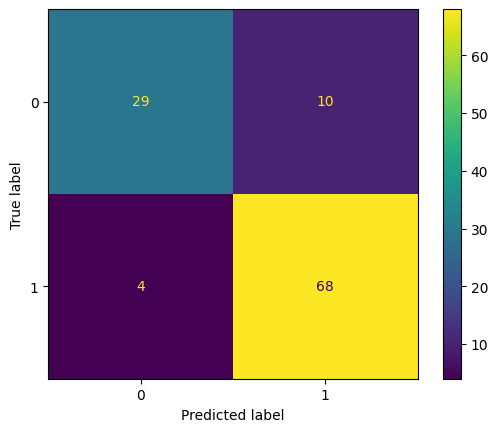

In [84]:
############# plot confusion matrix ############

from matplotlib import pyplot as plt
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, test_preds_SVC.round())
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.pink)


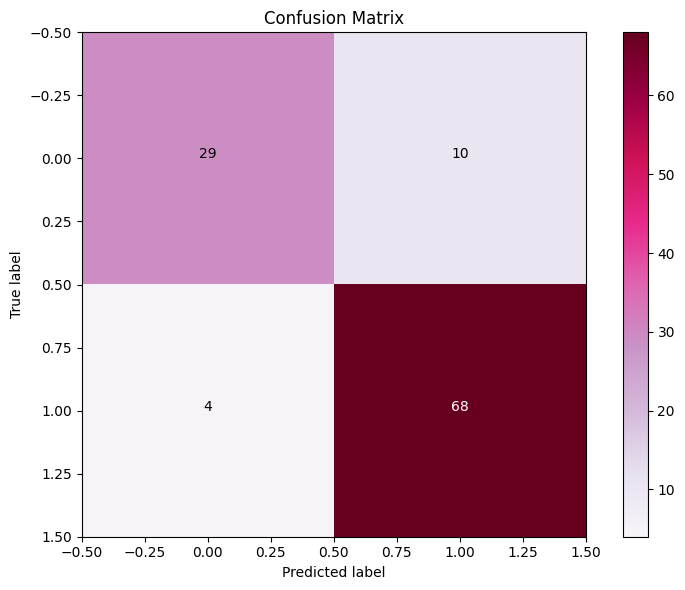

In [85]:
# Plot confusion matrix with custom color map

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)  # Set cmap to custom color map
plt.title('Confusion Matrix')
plt.colorbar()

# Adding ticks and labels
# tick_marks = np.arange(len(cm))
# plt.xticks(tick_marks, ['Class 0', 'Class 1', 'Class 2','Class 3','Class 4','class 5','class 6'])
# plt.yticks(tick_marks, ['Class 0', 'Class 1', 'Class 2'])

# Adding annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), #'d = integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() #improves the layout of plots by preventing overlapping elements such as axis labels, tick labels, and titles
plt.show()